## Project 3: Klasifikasi Penyebab Utama (Cause Category) Kecelakaan Pipa
Tujuan utama dari Proyek 3 ini adalah membangun dan mengevaluasi model machine learning yang mampu mengklasifikasikan atau memprediksi Kategori Penyebab Utama (Cause Category) dari sebuah insiden kecelakaan pipa. Dengan memahami faktor-faktor yang berkontribusi terhadap berbagai jenis penyebab, kita dapat mendukung upaya pencegahan yang lebih proaktif dan spesifik.

#### Tahap 1: Persiapan Data untuk Klasifikasi
##### 1.1: Memuat Data dan Seleksi Fitur Awal
Langkah pertama adalah memuat kembali dataset pipeline_accidents_processed_eda.csv yang merupakan hasil dari Project 1. Dataset ini sudah melalui pembersihan dan rekayasa fitur awal.

Selanjutnya, kita akan memilih fitur-fitur (prediktor) yang akan digunakan untuk memprediksi variabel target kita, yaitu Cause Category. Penting untuk tidak memasukkan Cause Subcategory sebagai fitur karena itu akan menjadi bocoran langsung dari target. Kita juga perlu mempertimbangkan relevansi fitur-fitur lain yang telah kita buat.

Variabel target Cause Category adalah variabel kategorikal, dan kita perlu memeriksa distribusinya untuk melihat apakah ada ketidakseimbangan kelas yang signifikan.

DataFrame berhasil dimuat dari 'pipeline_accidents_processed_eda.csv'.
Dimensi data: 2795 baris dan 62 kolom.

Jumlah fitur prediktor awal yang akan dipertimbangkan: 55

Distribusi Variabel Target (Cause Category):
Cause Category
MATERIAL/WELD/EQUIP FAILURE    1435
CORROSION                       592
INCORRECT OPERATION             378
NATURAL FORCE DAMAGE            118
ALL OTHER CAUSES                118
EXCAVATION DAMAGE                97
OTHER OUTSIDE FORCE DAMAGE       57
Name: count, dtype: int64


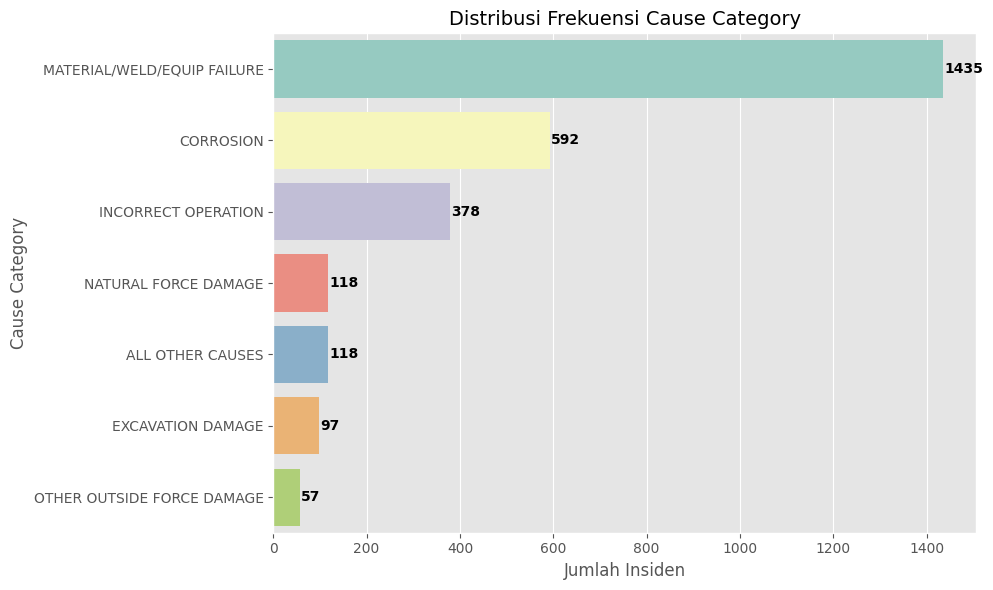


Peringatan: Terdeteksi potensi ketidakseimbangan kelas pada variabel target.
Rasio kelas minoritas terhadap mayoritas < 10%. Pertimbangkan teknik penanganan kelas tidak seimbang.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

# 1. Memuat Data yang Telah Diproses dari Proyek 1
nama_file_input = 'pipeline_accidents_processed_eda.csv' 
try:
    df_class = pd.read_csv(nama_file_input)
    print(f"DataFrame berhasil dimuat dari '{nama_file_input}'.")
    print(f"Dimensi data: {df_class.shape[0]} baris dan {df_class.shape[1]} kolom.")
except FileNotFoundError:
    print(f"ERROR: File '{nama_file_input}' tidak ditemukan. Pastikan Anda sudah menyimpan output dari Proyek 1.")
    df_class = pd.DataFrame() 
except Exception as e:
    print(f"Terjadi kesalahan saat memuat file: {e}")
    df_class = pd.DataFrame()

if not df_class.empty: 
    # 2. Seleksi Fitur Prediktor (X) dan Variabel Target (y)
    target_col = 'Cause Category'

    if target_col not in df_class.columns:
        print(f"ERROR: Kolom target '{target_col}' tidak ditemukan dalam DataFrame.")
    else:
        cols_to_exclude = [
            'Report Number', 'Supplemental Number', 'Accident Date/Time', 
            'Shutdown Date/Time', 'Restart Date/Time', 'Cause Subcategory'
        ]
        
        potential_predictor_cols = [col for col in df_class.columns if col not in cols_to_exclude and col != target_col]
        
        X = df_class[potential_predictor_cols].copy()
        y = df_class[target_col].copy()

        print(f"\nJumlah fitur prediktor awal yang akan dipertimbangkan: {len(X.columns)}")

        # 3. Analisis Variabel Target (y = Cause Category)
        print("\nDistribusi Variabel Target (Cause Category):")
        cause_counts = y.value_counts()
        print(cause_counts)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x=cause_counts.values, y=cause_counts.index, hue=cause_counts.index, palette='Set3', legend=False, orient='h', dodge=False)
        plt.title('Distribusi Frekuensi Cause Category', fontsize=14)
        plt.xlabel('Jumlah Insiden', fontsize=12)
        plt.ylabel('Cause Category', fontsize=12)
        for i, v in enumerate(cause_counts.values):
            plt.text(v + 3, i, str(v), color='black', va='center', fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        if len(cause_counts) > 1 and (cause_counts.min() / cause_counts.max()) < 0.1: # Cek kasar ketidakseimbangan
            print("\nPeringatan: Terdeteksi potensi ketidakseimbangan kelas pada variabel target.")
            print("Rasio kelas minoritas terhadap mayoritas < 10%. Pertimbangkan teknik penanganan kelas tidak seimbang.")
else:
    print("Proses dihentikan karena DataFrame tidak berhasil dimuat.")


##### 1.2: Persiapan Data Lanjutan (Encoding, Penanganan Imbalance, Split, Scaling)
Setelah memuat data dan melakukan seleksi fitur awal, langkah selanjutnya adalah mempersiapkan data secara menyeluruh untuk pemodelan klasifikasi. Ini melibatkan beberapa sub-tahapan penting:
1. Encoding Variabel Kategorikal: Fitur-fitur kategorikal dalam X perlu diubah menjadi format numerik. Kita akan menggunakan strategi yang mirip dengan Proyek 2: Frequency Encoding untuk fitur berkardinalitas tinggi (Operator Name, Accident City, Pipeline/Facility Name jika masih ada dan relevan) dan One-Hot Encoding untuk sisanya.
2. Penanganan Ketidakseimbangan Kelas: Distribusi Cause Category menunjukkan ketidakseimbangan yang signifikan. Jika tidak ditangani, model cenderung memprediksi kelas mayoritas dengan baik tetapi buruk pada kelas minoritas. Kita akan mencoba teknik SMOTE (Synthetic Minority Over-sampling Technique) pada data pelatihan untuk menyeimbangkan distribusi kelas dengan cara membuat sampel sintetis untuk kelas minoritas.
3. Pembagian Data: Dataset akan dibagi menjadi set pelatihan dan pengujian. SMOTE hanya akan diterapkan pada set pelatihan untuk mencegah kebocoran data.
4. Penskalaan Fitur: Fitur numerik akan diskalakan menggunakan StandardScaler setelah pembagian data dan setelah penerapan SMOTE pada data pelatihan.

In [17]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# Untuk SMOTE, Anda mungkin perlu menginstal imbalanced-learn: pip install imblearn
from imblearn.over_sampling import SMOTE

print("Memulai Persiapan Data Lanjutan untuk Klasifikasi...")

# --- 1. Pra-pemrosesan Encoding dan Penanganan NaN pada Fitur Kategorikal di X ---
X_prep = X.copy()


categorical_cols_prep = X_prep.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols_prep = X_prep.select_dtypes(include=np.number).columns.tolist()

for col in categorical_cols_prep:
    if X_prep[col].isnull().any():
        mode_val = X_prep[col].mode()[0] if not X_prep[col].mode().empty else 'UNKNOWN'
        X_prep[col].fillna(mode_val, inplace=True)
        print(f"NaN di kolom kategorikal '{col}' (dalam X_prep) diisi dengan '{mode_val}'.")
    
for col in numerical_cols_prep:
    if X_prep[col].isnull().any():
        median_val = X_prep[col].median()
        X_prep[col].fillna(median_val, inplace=True)
        print(f"NaN di kolom numerik '{col}' (dalam X_prep) diisi dengan median ({median_val:.2f}).")
    
high_card_cols_candidates = ['Operator Name', 'Accident City', 'Pipeline/Facility Name', 'Liquid Name', 'Liquid Subtype']
    
for col in high_card_cols_candidates:
    if col in X_prep.columns and X_prep[col].dtype == 'object':
        if X_prep[col].nunique() > 20:
            print(f"Menerapkan Frequency Encoding pada kolom: {col}")
            frequency_map = X_prep[col].value_counts(normalize=True)
            X_prep[col + '_freq_encoded'] = X_prep[col].map(frequency_map)
            X_prep.drop(col, axis=1, inplace=True)
            if col + '_freq_encoded' not in numerical_cols_prep:
                numerical_cols_prep.append(col + '_freq_encoded')
            if col in categorical_cols_prep:
                categorical_cols_prep.remove(col)

low_card_categorical_cols_for_ohe = [col for col in categorical_cols_prep if col in X_prep.columns and X_prep[col].dtype == 'object']
if low_card_categorical_cols_for_ohe:
    print(f"Menerapkan One-Hot Encoding pada kolom: {low_card_categorical_cols_for_ohe}")
    X_prep = pd.get_dummies(X_prep, columns=low_card_categorical_cols_for_ohe, drop_first=True)
    
print(f"Dimensi X setelah encoding awal: {X_prep.shape}")

Memulai Persiapan Data Lanjutan untuk Klasifikasi...
Menerapkan Frequency Encoding pada kolom: Operator Name
Menerapkan Frequency Encoding pada kolom: Accident City
Menerapkan Frequency Encoding pada kolom: Pipeline/Facility Name
Menerapkan Frequency Encoding pada kolom: Liquid Name
Menerapkan One-Hot Encoding pada kolom: ['Pipeline Location', 'Pipeline Type', 'Liquid Type', 'Liquid Subtype', 'Accident County', 'Accident State', 'Liquid Ignition', 'Liquid Explosion', 'Pipeline Shutdown', 'Accident_Month_Name', 'Accident_DayOfWeek_Name', 'Net_Loss_Category']
Dimensi X setelah encoding awal: (2795, 809)


In [18]:
# --- 2. Encoding Variabel Target (y) ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("\nLabel Encoding untuk Variabel Target (Cause Category):")
for i, class_name in enumerate(le.classes_):
    print(f"  Kelas '{class_name}' di-encode menjadi {i}")
    
target_label_mapping = {i: class_name for i, class_name in enumerate(le.classes_)}


Label Encoding untuk Variabel Target (Cause Category):
  Kelas 'ALL OTHER CAUSES' di-encode menjadi 0
  Kelas 'CORROSION' di-encode menjadi 1
  Kelas 'EXCAVATION DAMAGE' di-encode menjadi 2
  Kelas 'INCORRECT OPERATION' di-encode menjadi 3
  Kelas 'MATERIAL/WELD/EQUIP FAILURE' di-encode menjadi 4
  Kelas 'NATURAL FORCE DAMAGE' di-encode menjadi 5
  Kelas 'OTHER OUTSIDE FORCE DAMAGE' di-encode menjadi 6


In [19]:
# --- 3. Pembagian Data (Train-Test Split) ---
print("\nMelakukan pembagian data menjadi set pelatihan dan pengujian...")
X_train, X_test, y_train, y_test = train_test_split(X_prep, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded)

print(f"Ukuran X_train sebelum SMOTE: {X_train.shape}, Ukuran y_train sebelum SMOTE: {y_train.shape}")
print(f"Ukuran X_test: {X_test.shape}, Ukuran y_test: {y_test.shape}")
    
# Cek distribusi kelas pada y_train sebelum SMOTE
print("\nDistribusi kelas pada y_train SEBELUM SMOTE:")
unique_train, counts_train = np.unique(y_train, return_counts=True)
for i, class_idx in enumerate(unique_train):
    print(f"  Kelas {target_label_mapping[class_idx]} (Encoded: {class_idx}): {counts_train[i]} sampel")


Melakukan pembagian data menjadi set pelatihan dan pengujian...
Ukuran X_train sebelum SMOTE: (2096, 809), Ukuran y_train sebelum SMOTE: (2096,)
Ukuran X_test: (699, 809), Ukuran y_test: (699,)

Distribusi kelas pada y_train SEBELUM SMOTE:
  Kelas ALL OTHER CAUSES (Encoded: 0): 88 sampel
  Kelas CORROSION (Encoded: 1): 444 sampel
  Kelas EXCAVATION DAMAGE (Encoded: 2): 73 sampel
  Kelas INCORRECT OPERATION (Encoded: 3): 283 sampel
  Kelas MATERIAL/WELD/EQUIP FAILURE (Encoded: 4): 1076 sampel
  Kelas NATURAL FORCE DAMAGE (Encoded: 5): 89 sampel
  Kelas OTHER OUTSIDE FORCE DAMAGE (Encoded: 6): 43 sampel


In [20]:
# --- 4. Penanganan Ketidakseimbangan Kelas dengan SMOTE (HANYA pada data pelatihan) ---
print("\nMenerapkan SMOTE pada data pelatihan untuk menangani ketidakseimbangan kelas...")
try:
    smote = SMOTE(random_state=42, k_neighbors=2)
    min_class_count_train = np.min(counts_train)
    if min_class_count_train <= smote.k_neighbors:
        new_k = max(1, min_class_count_train - 1)
        print(f"Peringatan: Kelas minoritas hanya memiliki {min_class_count_train} sampel. Menyesuaikan k_neighbors untuk SMOTE menjadi {new_k}.")
        smote = SMOTE(random_state=42, k_neighbors=new_k)

    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    print("SMOTE berhasil diterapkan pada data pelatihan.")
    print(f"Ukuran X_train setelah SMOTE: {X_train_smote.shape}, Ukuran y_train setelah SMOTE: {y_train_smote.shape}")

    print("\nDistribusi kelas pada y_train SETELAH SMOTE:")
    unique_smote, counts_smote = np.unique(y_train_smote, return_counts=True)
    for i, class_idx in enumerate(unique_smote):
        print(f"  Kelas {target_label_mapping[class_idx]} (Encoded: {class_idx}): {counts_smote[i]} sampel")
            
except Exception as e:
    print(f"Error saat menerapkan SMOTE: {e}. Melanjutkan tanpa SMOTE.")
    X_train_smote, y_train_smote = X_train, y_train # Gunakan data asli jika SMOTE gagal


Menerapkan SMOTE pada data pelatihan untuk menangani ketidakseimbangan kelas...
SMOTE berhasil diterapkan pada data pelatihan.
Ukuran X_train setelah SMOTE: (7532, 809), Ukuran y_train setelah SMOTE: (7532,)

Distribusi kelas pada y_train SETELAH SMOTE:
  Kelas ALL OTHER CAUSES (Encoded: 0): 1076 sampel
  Kelas CORROSION (Encoded: 1): 1076 sampel
  Kelas EXCAVATION DAMAGE (Encoded: 2): 1076 sampel
  Kelas INCORRECT OPERATION (Encoded: 3): 1076 sampel
  Kelas MATERIAL/WELD/EQUIP FAILURE (Encoded: 4): 1076 sampel
  Kelas NATURAL FORCE DAMAGE (Encoded: 5): 1076 sampel
  Kelas OTHER OUTSIDE FORCE DAMAGE (Encoded: 6): 1076 sampel


In [21]:
# --- 5. Penskalaan Fitur (Feature Scaling) ---
if isinstance(X_train_smote, pd.DataFrame):
    numerical_cols_for_scaling = X_train_smote.select_dtypes(include=np.number).columns.tolist()
    scaled_column_names = numerical_cols_for_scaling 
else: 
    numerical_cols_for_scaling = X_prep.columns.tolist() 
    scaled_column_names = numerical_cols_for_scaling

if not numerical_cols_for_scaling:
    X_train_processed_class = pd.DataFrame(X_train_smote, columns=X_prep.columns) if not isinstance(X_train_smote, pd.DataFrame) else X_train_smote
    X_test_processed_class = pd.DataFrame(X_test, columns=X_prep.columns) if not isinstance(X_test, pd.DataFrame) else X_test
else:
    scaler_class = StandardScaler()
    if not isinstance(X_train_smote, pd.DataFrame):
        X_train_smote_df = pd.DataFrame(X_train_smote, columns=X_prep.columns)
    else:
        X_train_smote_df = X_train_smote

    if not isinstance(X_test, pd.DataFrame):
        X_test_df = pd.DataFrame(X_test, columns=X_prep.columns)
    else:
        X_test_df = X_test
            
    X_train_scaled_array_class = scaler_class.fit_transform(X_train_smote_df[scaled_column_names])
    X_test_scaled_array_class = scaler_class.transform(X_test_df[scaled_column_names])

    X_train_processed_class = pd.DataFrame(X_train_scaled_array_class, columns=scaled_column_names) 
    
    X_test_processed_class = pd.DataFrame(X_test_scaled_array_class, columns=scaled_column_names, index=X_test_df.index)

#### Tahap 2: Pemilihan dan Pelatihan Model Klasifikasi 
Setelah data kita siap dan bersih, langkah berikutnya adalah memilih beberapa algoritma machine learning untuk klasifikasi, melatihnya dengan data pelatihan (X_train_processed_class dan y_train_smote), dan kemudian melihat seberapa baik performanya dalam memprediksi Cause Category. Kita akan memulai dengan beberapa model klasifikasi yang umum digunakan.

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report 

if 'X_train_processed_class' in locals() and 'y_train_smote' in locals() and \
   'X_test_processed_class' in locals() and not X_train_processed_class.empty:
    
    print("Memulai pelatihan model klasifikasi awal...")

    # Inisialisasi model-model
    # 1. Logistic Regression
    logreg_model = LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr', max_iter=1000)

    # 2. K-Nearest Neighbors (KNN)
    knn_model = KNeighborsClassifier(n_neighbors=5)

    # 3. Decision Tree Classifier
    dt_class_model = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=10)

    # 4. Random Forest Classifier
    rf_class_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, 
                                            max_depth=10, min_samples_split=10)

    # 5. Gradient Boosting Classifier
    gb_class_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, 
                                                random_state=42, min_samples_split=10)
                                                
    # 6. Gaussian Naive Bayes
    gnb_model = GaussianNB()


    classification_models = {
        "Logistic Regression": logreg_model,
        "K-Nearest Neighbors": knn_model,
        "Decision Tree": dt_class_model,
        "Random Forest": rf_class_model,
        "Gradient Boosting": gb_class_model,
        "Gaussian Naive Bayes": gnb_model
    }


    predictions_class_test = {}
    trained_classification_models = {}

    for name, model in classification_models.items():
        print(f"\nMelatih model: {name}...")
        try:
            model.fit(X_train_processed_class, y_train_smote)
            y_pred_class_test = model.predict(X_test_processed_class)
            
            predictions_class_test[name] = y_pred_class_test
            trained_classification_models[name] = model
            
            print(f"Model {name} berhasil dilatih dan prediksi pada data tes dibuat.")
        except Exception as e:
            print(f"Error saat melatih atau memprediksi dengan {name}: {e}")
            predictions_class_test[name] = None
            trained_classification_models[name] = None

    print("\nPelatihan semua model klasifikasi awal selesai.")
else:
    print("Data pelatihan (X_train_processed_class, y_train_smote) atau data tes (X_test_processed_class) belum terdefinisi.")

Memulai pelatihan model klasifikasi awal...

Melatih model: Logistic Regression...
Model Logistic Regression berhasil dilatih dan prediksi pada data tes dibuat.

Melatih model: K-Nearest Neighbors...
Model K-Nearest Neighbors berhasil dilatih dan prediksi pada data tes dibuat.

Melatih model: Decision Tree...
Model Decision Tree berhasil dilatih dan prediksi pada data tes dibuat.

Melatih model: Random Forest...
Model Random Forest berhasil dilatih dan prediksi pada data tes dibuat.

Melatih model: Gradient Boosting...
Model Gradient Boosting berhasil dilatih dan prediksi pada data tes dibuat.

Melatih model: Gaussian Naive Bayes...
Model Gaussian Naive Bayes berhasil dilatih dan prediksi pada data tes dibuat.

Pelatihan semua model klasifikasi awal selesai.


Setelah melatih berbagai model klasifikasi, kita perlu mengevaluasi seberapa baik mereka dalam memprediksi Cause Category pada data pengujian. Mengingat kita telah menangani ketidakseimbangan kelas dengan SMOTE pada data pelatihan, penting untuk melihat metrik yang memberikan gambaran komprehensif, bukan hanya akurasi.

Memulai evaluasi model klasifikasi...


============================== Mengevaluasi Model: Logistic Regression ==============================

Akurasi Model Logistic Regression: 0.2718

Laporan Klasifikasi:
                             precision    recall  f1-score   support

           ALL OTHER CAUSES       0.06      0.13      0.08        30
                  CORROSION       0.32      0.24      0.28       148
          EXCAVATION DAMAGE       0.08      0.29      0.13        24
        INCORRECT OPERATION       0.13      0.09      0.11        95
MATERIAL/WELD/EQUIP FAILURE       0.59      0.34      0.43       359
       NATURAL FORCE DAMAGE       0.12      0.38      0.18        29
 OTHER OUTSIDE FORCE DAMAGE       0.03      0.14      0.05        14

                   accuracy                           0.27       699
                  macro avg       0.19      0.23      0.18       699
               weighted avg       0.40      0.27      0.31       699



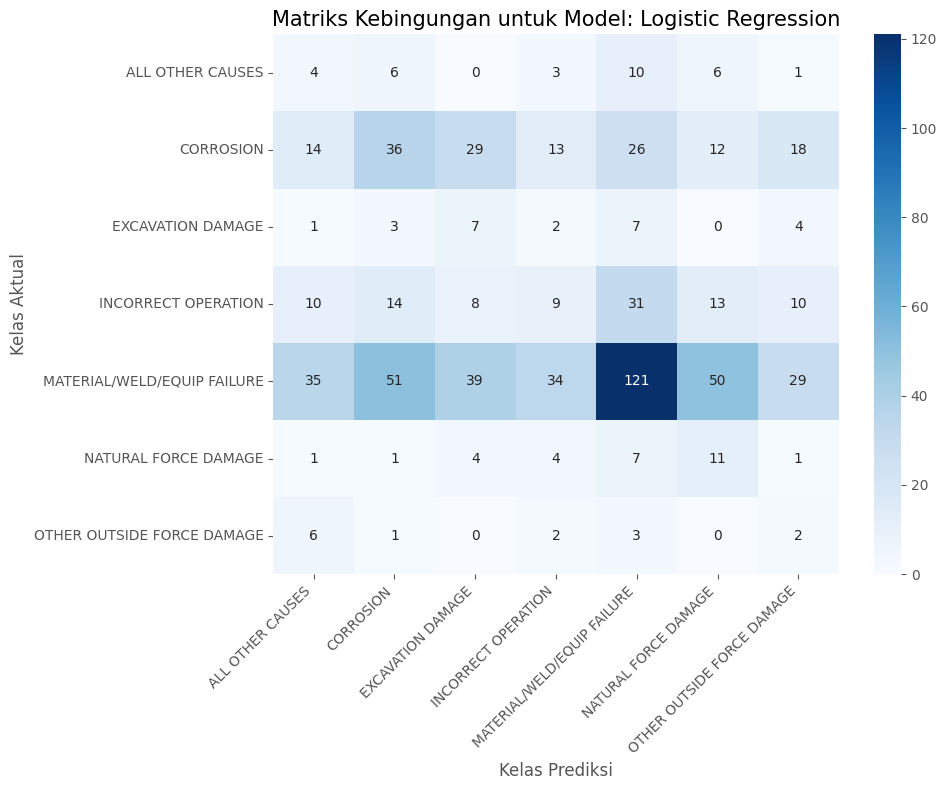



============================== Mengevaluasi Model: K-Nearest Neighbors ==============================

Akurasi Model K-Nearest Neighbors: 0.3119

Laporan Klasifikasi:
                             precision    recall  f1-score   support

           ALL OTHER CAUSES       0.15      0.30      0.20        30
                  CORROSION       0.33      0.37      0.35       148
          EXCAVATION DAMAGE       0.09      0.17      0.11        24
        INCORRECT OPERATION       0.18      0.28      0.22        95
MATERIAL/WELD/EQUIP FAILURE       0.61      0.33      0.43       359
       NATURAL FORCE DAMAGE       0.10      0.21      0.13        29
 OTHER OUTSIDE FORCE DAMAGE       0.00      0.00      0.00        14

                   accuracy                           0.31       699
                  macro avg       0.21      0.24      0.21       699
               weighted avg       0.42      0.31      0.34       699



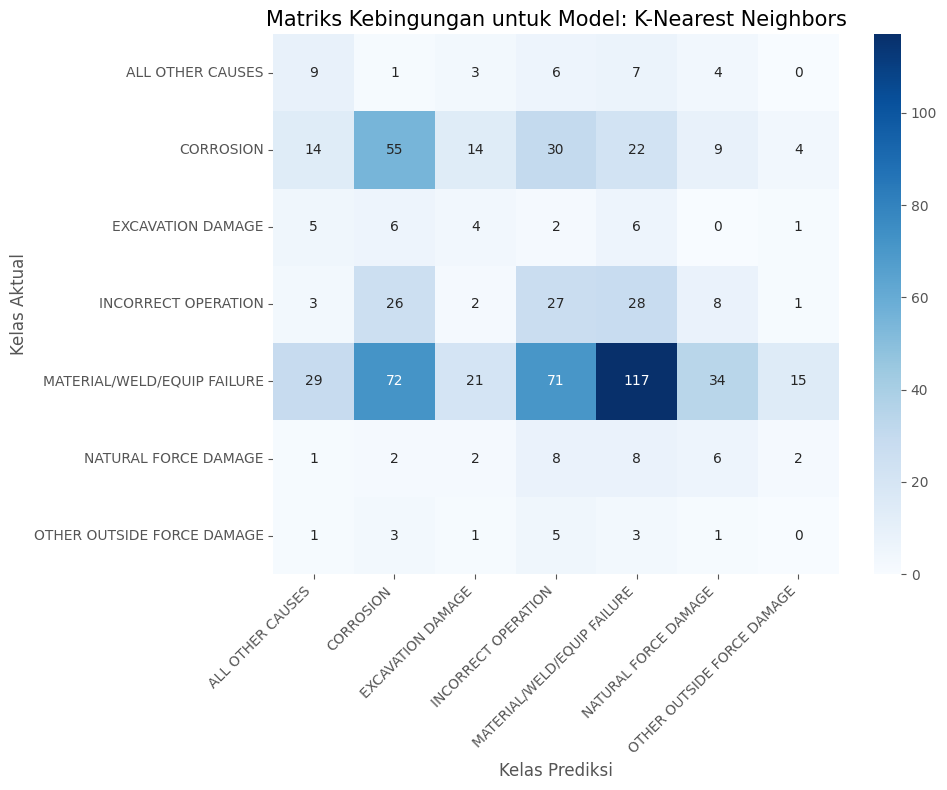



============================== Mengevaluasi Model: Decision Tree ==============================

Akurasi Model Decision Tree: 0.3419

Laporan Klasifikasi:
                             precision    recall  f1-score   support

           ALL OTHER CAUSES       0.04      0.03      0.04        30
                  CORROSION       0.40      0.42      0.41       148
          EXCAVATION DAMAGE       0.17      0.42      0.24        24
        INCORRECT OPERATION       0.26      0.52      0.35        95
MATERIAL/WELD/EQUIP FAILURE       0.62      0.31      0.41       359
       NATURAL FORCE DAMAGE       0.08      0.17      0.11        29
 OTHER OUTSIDE FORCE DAMAGE       0.04      0.07      0.05        14

                   accuracy                           0.34       699
                  macro avg       0.23      0.28      0.23       699
               weighted avg       0.45      0.34      0.36       699



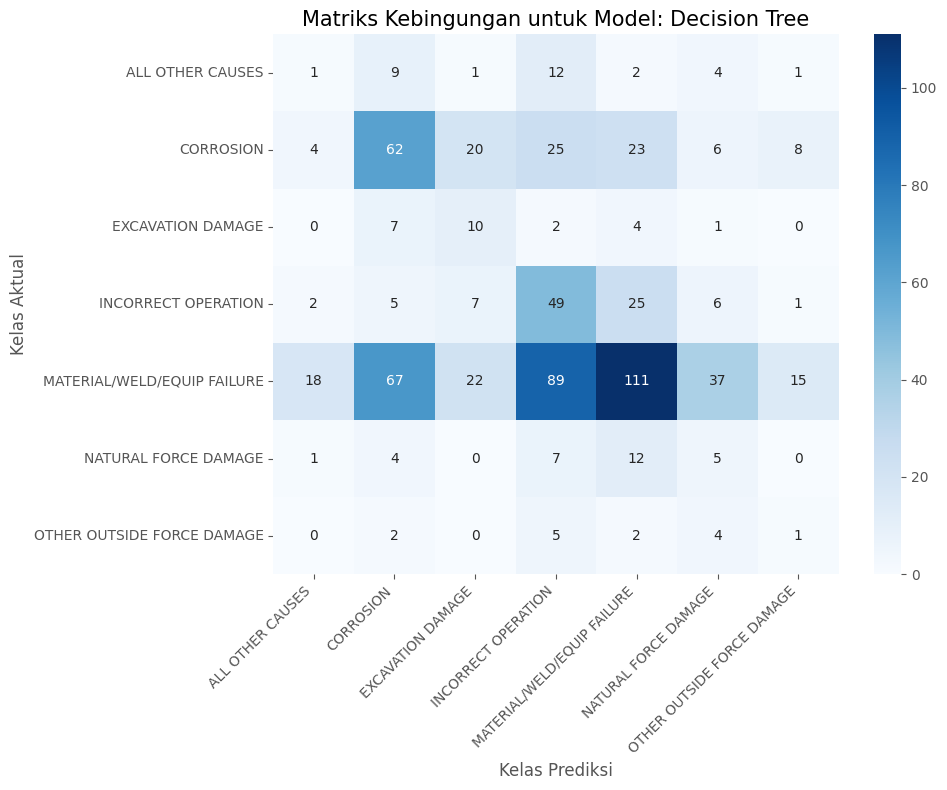



============================== Mengevaluasi Model: Random Forest ==============================

Akurasi Model Random Forest: 0.4921

Laporan Klasifikasi:
                             precision    recall  f1-score   support

           ALL OTHER CAUSES       0.14      0.10      0.12        30
                  CORROSION       0.48      0.55      0.51       148
          EXCAVATION DAMAGE       0.28      0.50      0.36        24
        INCORRECT OPERATION       0.32      0.36      0.34        95
MATERIAL/WELD/EQUIP FAILURE       0.67      0.58      0.62       359
       NATURAL FORCE DAMAGE       0.19      0.21      0.20        29
 OTHER OUTSIDE FORCE DAMAGE       0.06      0.07      0.06        14

                   accuracy                           0.49       699
                  macro avg       0.30      0.34      0.31       699
               weighted avg       0.51      0.49      0.50       699



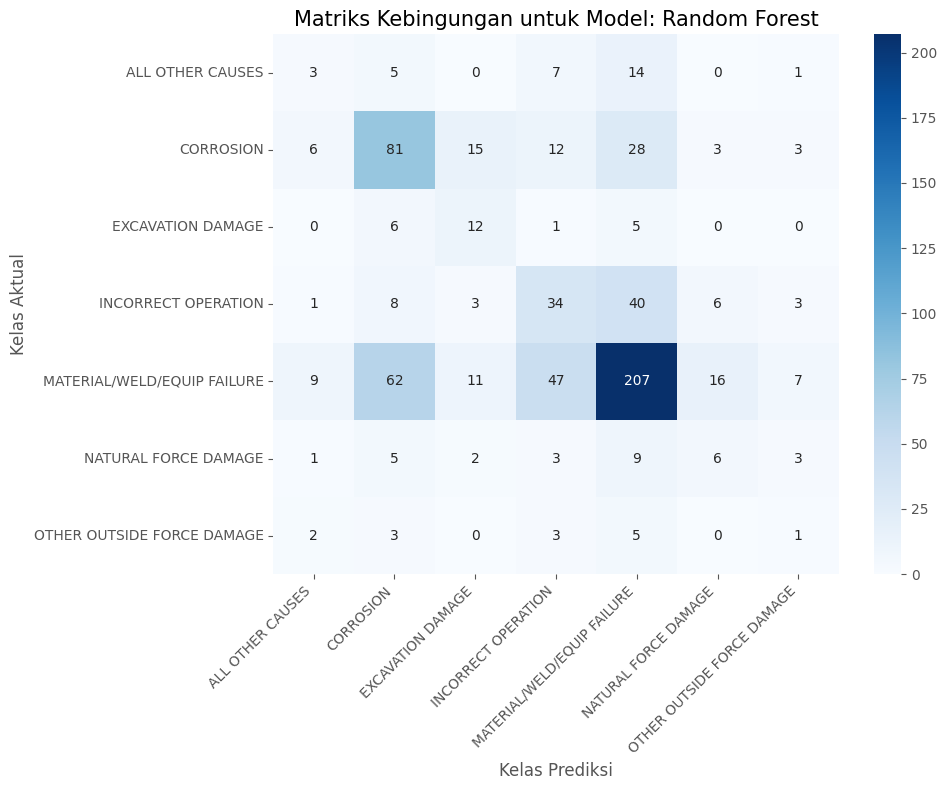



============================== Mengevaluasi Model: Gradient Boosting ==============================

Akurasi Model Gradient Boosting: 0.5293

Laporan Klasifikasi:
                             precision    recall  f1-score   support

           ALL OTHER CAUSES       0.31      0.13      0.19        30
                  CORROSION       0.49      0.49      0.49       148
          EXCAVATION DAMAGE       0.37      0.29      0.33        24
        INCORRECT OPERATION       0.33      0.23      0.27        95
MATERIAL/WELD/EQUIP FAILURE       0.61      0.73      0.66       359
       NATURAL FORCE DAMAGE       0.24      0.14      0.17        29
 OTHER OUTSIDE FORCE DAMAGE       0.00      0.00      0.00        14

                   accuracy                           0.53       699
                  macro avg       0.33      0.29      0.30       699
               weighted avg       0.50      0.53      0.51       699



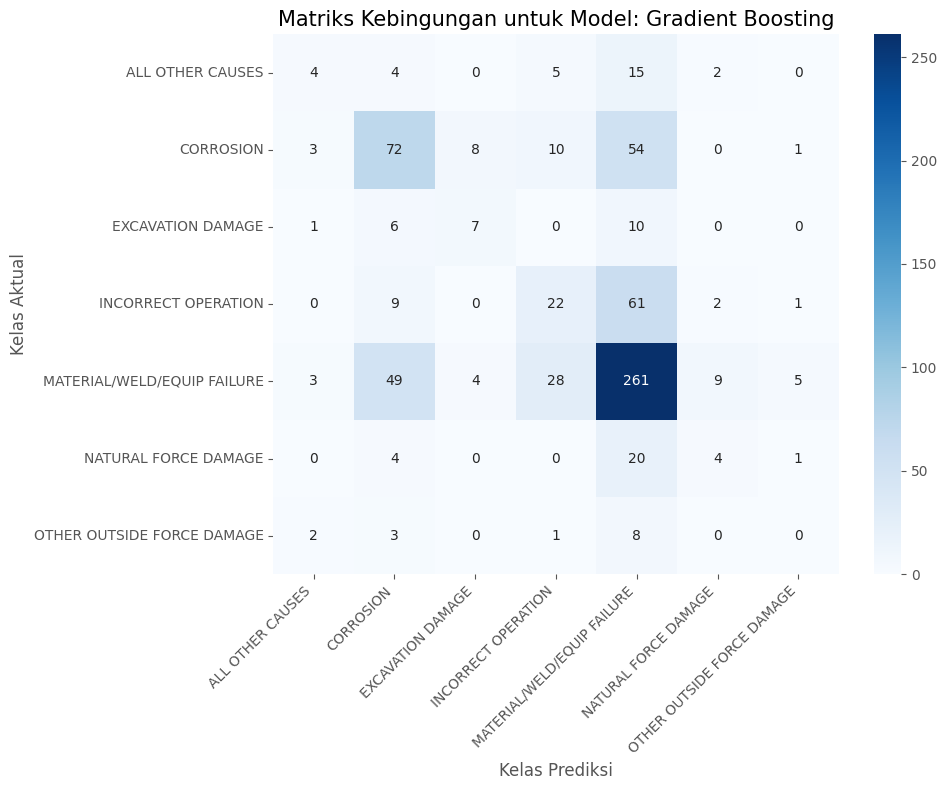



============================== Mengevaluasi Model: Gaussian Naive Bayes ==============================

Akurasi Model Gaussian Naive Bayes: 0.2060

Laporan Klasifikasi:
                             precision    recall  f1-score   support

           ALL OTHER CAUSES       0.00      0.00      0.00        30
                  CORROSION       0.23      0.83      0.35       148
          EXCAVATION DAMAGE       0.13      0.33      0.19        24
        INCORRECT OPERATION       0.50      0.01      0.02        95
MATERIAL/WELD/EQUIP FAILURE       0.75      0.01      0.02       359
       NATURAL FORCE DAMAGE       0.10      0.28      0.15        29
 OTHER OUTSIDE FORCE DAMAGE       0.11      0.07      0.09        14

                   accuracy                           0.21       699
                  macro avg       0.26      0.22      0.12       699
               weighted avg       0.51      0.21      0.10       699



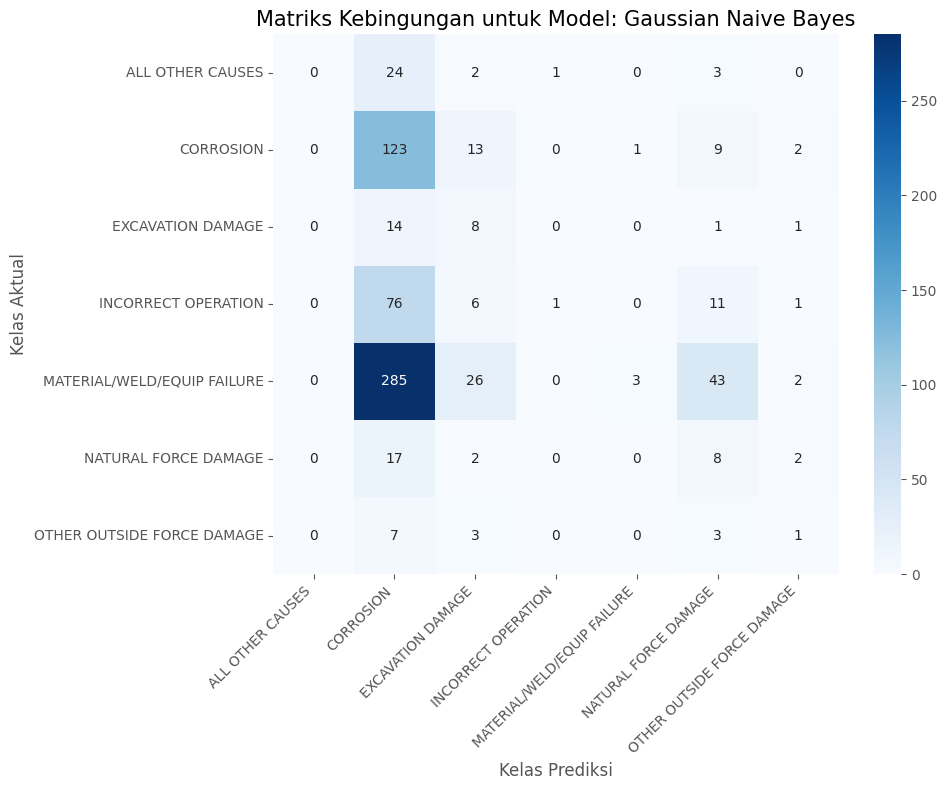



============================== Ringkasan Hasil Evaluasi Model Klasifikasi ==============================
               Model  Accuracy  F1-score (Weighted Avg)
   Gradient Boosting    0.5293                   0.5071
       Random Forest    0.4921                   0.4992
       Decision Tree    0.3419                   0.3604
 K-Nearest Neighbors    0.3119                   0.3407
 Logistic Regression    0.2718                   0.3104
Gaussian Naive Bayes    0.2060                   0.1008


In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Untuk DataFrame ringkasan

if 'y_test' in locals() and 'predictions_class_test' in locals() and predictions_class_test and 'target_label_mapping' in locals():
    print("Memulai evaluasi model klasifikasi...")

    class_names_original = [target_label_mapping[i] for i in sorted(target_label_mapping.keys())]
    
    classification_results_summary = []

    for name, y_pred_encoded in predictions_class_test.items():
        if y_pred_encoded is None:
            print(f"\nModel {name} tidak berhasil dilatih atau membuat prediksi, evaluasi dilewati.")
            continue

        print(f"\n\n" + "="*30 + f" Mengevaluasi Model: {name} " + "="*30)

        accuracy = accuracy_score(y_test, y_pred_encoded)
        print(f"\nAkurasi Model {name}: {accuracy:.4f}")

        print("\nLaporan Klasifikasi:")
        unique_labels_in_data = np.unique(np.concatenate((y_test, y_pred_encoded)))
        current_target_names = [target_label_mapping[i] for i in unique_labels_in_data]
        
        try:
            report = classification_report(y_test, y_pred_encoded, 
                                           labels=unique_labels_in_data, 
                                           target_names=current_target_names, 
                                           zero_division=0)
            print(report)
        except ValueError as ve: 
            print(f"Tidak dapat membuat laporan klasifikasi untuk {name} karena perbedaan label: {ve}")
            print("Mencoba dengan label yang ada di y_test saja...")
            try:
                report = classification_report(y_test, y_pred_encoded, 
                                           labels=np.unique(y_test), 
                                           target_names=[target_label_mapping[i] for i in np.unique(y_test)], 
                                           zero_division=0)
                print(report)
            except Exception as e_report:
                 print(f"Gagal membuat laporan klasifikasi alternatif untuk {name}: {e_report}")

        report_dict = classification_report(y_test, y_pred_encoded, 
                                            labels=unique_labels_in_data, 
                                            target_names=current_target_names, 
                                            zero_division=0, output_dict=True)
        f1_weighted = report_dict['weighted avg']['f1-score']
        
        classification_results_summary.append({
            "Model": name,
            "Accuracy": accuracy,
            "F1-score (Weighted Avg)": f1_weighted
        })

        cm = confusion_matrix(y_test, y_pred_encoded, labels=unique_labels_in_data)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=current_target_names, yticklabels=current_target_names)
        plt.title(f'Matriks Kebingungan untuk Model: {name}', fontsize=15)
        plt.xlabel('Kelas Prediksi', fontsize=12)
        plt.ylabel('Kelas Aktual', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    if classification_results_summary:
        classification_results_df = pd.DataFrame(classification_results_summary).sort_values(by="F1-score (Weighted Avg)", ascending=False)
        print("\n\n" + "="*30 + " Ringkasan Hasil Evaluasi Model Klasifikasi " + "="*30)
        print(classification_results_df.round(4).to_string(index=False))

else:
    print("Variabel y_test, predictions_class_test, atau target_label_mapping belum terdefinisi. Jalankan langkah sebelumnya.")

Setelah mengevaluasi berbagai model klasifikasi, kita melihat bahwa Gradient Boosting Classifier menunjukkan performa F1-score (Weighted Avg) tertinggi, menjadikannya kandidat model terbaik kita sejauh ini. Langkah selanjutnya adalah mencoba memahami fitur mana yang dianggap paling penting oleh model ini dalam mengklasifikasikan Cause Category

Menganalisis Fitur Penting dari Model Gradient Boosting...

Top 15 Fitur Terpenting menurut Gradient Boosting Classifier:
                        feature  importance
          Avg_AllCosts_Operator    0.074839
          Property Damage Costs    0.065897
Unintentional Release (Barrels)    0.065327
              Accident Latitude    0.053989
       Emergency Response Costs    0.052273
        Shutdown_Duration_Hours    0.049733
             Accident Longitude    0.049624
Environmental Remediation Costs    0.041608
    Previous_Incidents_Operator    0.041342
                    Operator ID    0.040866
                      All Costs    0.039634
      Liquid Recovery (Barrels)    0.039118
           Lost Commodity Costs    0.034262
                 Accident_Month    0.033700
     Accident City_freq_encoded    0.033630


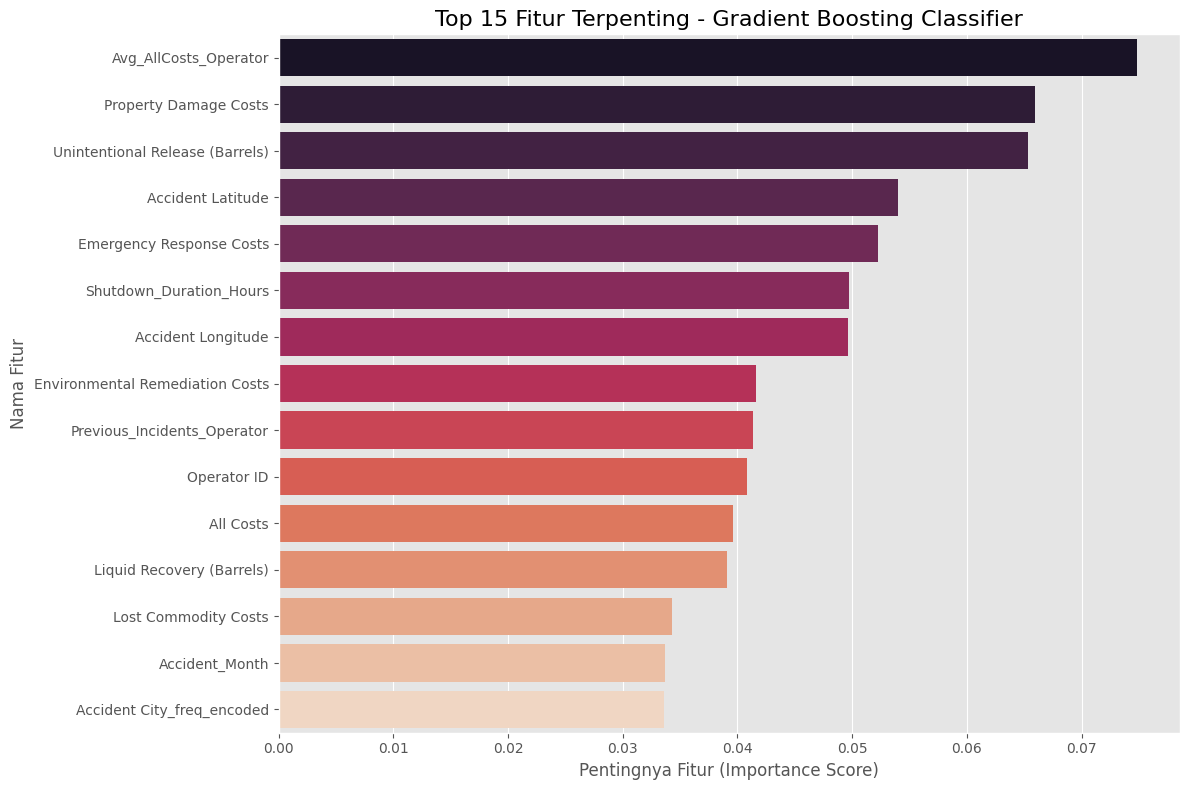

In [24]:
if 'trained_classification_models' in locals() and \
   "Gradient Boosting" in trained_classification_models and \
   trained_classification_models["Gradient Boosting"] is not None and \
   'X_train_processed_class' in locals() and not X_train_processed_class.empty:
    
    print("Menganalisis Fitur Penting dari Model Gradient Boosting...")
    
    gb_best_model_class = trained_classification_models["Gradient Boosting"]
    
    importances_class = gb_best_model_class.feature_importances_

    if isinstance(X_train_processed_class, pd.DataFrame):
        feature_names_class = X_train_processed_class.columns
    elif 'X_prep' in locals() and isinstance(X_prep, pd.DataFrame): 
        feature_names_class = X_prep.columns 
    else:
        print("Tidak dapat menentukan nama fitur. Pastikan X_train_processed_class adalah DataFrame atau X_prep tersedia.")
        feature_names_class = [f"feature_{i}" for i in range(X_train_processed_class.shape[1])]

    feature_importance_class_df = pd.DataFrame({'feature': feature_names_class, 'importance': importances_class})
    feature_importance_class_df = feature_importance_class_df.sort_values(by='importance', ascending=False)

    top_n_features_class = 15 
    print(f"\nTop {top_n_features_class} Fitur Terpenting menurut Gradient Boosting Classifier:")
    print(feature_importance_class_df.head(top_n_features_class).to_string(index=False))

    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', 
                data=feature_importance_class_df.head(top_n_features_class), 
                hue='feature', palette='rocket', legend=False, dodge=False)
    plt.title(f'Top {top_n_features_class} Fitur Terpenting - Gradient Boosting Classifier', fontsize=16)
    plt.xlabel('Pentingnya Fitur (Importance Score)', fontsize=12)
    plt.ylabel('Nama Fitur', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("Model Gradient Boosting belum dilatih atau data yang diperlukan tidak tersedia.")


Fitur-fitur seperti Avg_AllCosts_Operator, Property Damage Costs, Unintentional Release (Barrels), dan Accident Latitude memiliki skor kepentingan yang relatif tinggi. Ini menunjukkan bahwa karakteristik operator terkait biaya rata-rata, besarnya kerusakan properti, volume tumpahan, dan lokasi geografis (lintang) menjadi prediktor penting bagi model dalam menentukan kategori penyebab.

Fitur lain seperti Emergency Response Costs, Shutdown_Duration_Hours, Accident Longitude, Environmental Remediation Costs, dan Previous_Incidents_Operator juga memberikan kontribusi yang cukup berarti.

Menariknya, Operator ID dan All Costs (total biaya aktual insiden) juga masuk dalam 15 besar, yang mungkin perlu dipertimbangkan apakah ini bisa menjadi data leakage jika All Costs secara tidak langsung mencerminkan penyebab. Namun, karena Cause Category adalah target kita, dan biaya adalah akibat, mungkin ini masih bisa diterima sebagai fitur yang berkorelasi dengan jenis penyebab tertentu.

Meskipun Gradient Boosting sudah memberikan hasil F1-score tertinggi (sekitar 0.5071) sejauh ini, performanya mungkin masih bisa ditingkatkan dengan menyetel hyperparameter-nya. Proses ini bertujuan untuk menemukan kombinasi parameter model yang menghasilkan performa terbaik pada data validasi silang. Kita akan menggunakan RandomizedSearchCV untuk efisiensi.

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score # Untuk evaluasi
import numpy as np 
import pandas as pd

if 'X_train_processed_class' in locals() and 'y_train_smote' in locals() and \
   'X_test_processed_class' in locals() and 'y_test' in locals() and \
   'trained_classification_models' in locals() and "Gradient Boosting" in trained_classification_models and \
   trained_classification_models["Gradient Boosting"] is not None and 'target_label_mapping' in locals():

    print("\nMemulai Penyetelan Hyperparameter untuk Gradient Boosting (menggunakan RandomizedSearchCV)...")
    print("Proses ini mungkin memerlukan waktu beberapa menit...")

    param_dist_gb = {
        'n_estimators': [100, 150, 200, 250],         # Jumlah pohon
        'learning_rate': [0.01, 0.05, 0.1, 0.2],       # Laju pembelajaran
        'max_depth': [3, 4, 5, 6, 7],                  # Kedalaman maksimum pohon
        'min_samples_split': [10, 20, 30, 40],         # Jumlah minimum sampel untuk membagi node
        'min_samples_leaf': [5, 10, 15, 20],           # Jumlah minimum sampel pada leaf node
        'subsample': [0.7, 0.8, 0.9, 1.0]              # Fraksi sampel untuk melatih setiap pohon
    }

    gb_base_for_tuning = GradientBoostingClassifier(random_state=42)
    gb_random_search = RandomizedSearchCV(estimator=gb_base_for_tuning, 
                                          param_distributions=param_dist_gb, 
                                          n_iter=25,
                                          cv=3,   
                                          verbose=1, 
                                          random_state=42, 
                                          n_jobs=-1, 
                                          scoring='f1_weighted')

    try:
        gb_random_search.fit(X_train_processed_class, y_train_smote)
        print("\nPenyetelan Hyperparameter Selesai.")
        print("Parameter Terbaik yang Ditemukan untuk Gradient Boosting:")
        print(gb_random_search.best_params_)
        best_gb_model_tuned = gb_random_search.best_estimator_
        trained_classification_models["Gradient Boosting Tuned"] = best_gb_model_tuned
        print("\n--- Mengevaluasi Model Gradient Boosting (Setelah Tuning) ---")
        y_pred_class_test_tuned = best_gb_model_tuned.predict(X_test_processed_class)
        
        accuracy_tuned = accuracy_score(y_test, y_pred_class_test_tuned)
        f1_weighted_tuned = f1_score(y_test, y_pred_class_test_tuned, average='weighted', zero_division=0)
        
        print(f"\nAkurasi Model (Tuned): {accuracy_tuned:.4f}")
        print(f"F1-score (Weighted Avg) (Tuned): {f1_weighted_tuned:.4f}")

        print("\nLaporan Klasifikasi (Tuned):")
        unique_labels_in_data_tuned = np.unique(np.concatenate((y_test, y_pred_class_test_tuned)))
        current_target_names_tuned = [target_label_mapping.get(i, f"Unknown_Label_{i}") for i in unique_labels_in_data_tuned]
        
        report_tuned = classification_report(y_test, y_pred_class_test_tuned, 
                                             labels=unique_labels_in_data_tuned, 
                                             target_names=current_target_names_tuned, 
                                             zero_division=0)
        print(report_tuned)
        if 'classification_results_summary' in locals() and isinstance(classification_results_summary, list):
            classification_results_summary.append({
                "Model": "Gradient Boosting Tuned",
                "Accuracy": accuracy_tuned,
                "F1-score (Weighted Avg)": f1_weighted_tuned
            })
            classification_results_df_updated = pd.DataFrame(classification_results_summary).sort_values(by="F1-score (Weighted Avg)", ascending=False)
            print("\n\n" + "="*30 + " Ringkasan Hasil Evaluasi Model (Termasuk Tuned) " + "="*30)
            print(classification_results_df_updated.round(4).to_string(index=False))

    except Exception as e:
        print(f"Error saat penyetelan hyperparameter untuk Gradient Boosting: {e}")
else:
    print("Data atau model yang diperlukan untuk penyetelan hyperparameter Gradient Boosting tidak tersedia.")



Memulai Penyetelan Hyperparameter untuk Gradient Boosting (menggunakan RandomizedSearchCV)...
Proses ini mungkin memerlukan waktu beberapa menit...
Fitting 3 folds for each of 25 candidates, totalling 75 fits

Penyetelan Hyperparameter Selesai.
Parameter Terbaik yang Ditemukan untuk Gradient Boosting:
{'subsample': 0.7, 'n_estimators': 250, 'min_samples_split': 40, 'min_samples_leaf': 15, 'max_depth': 7, 'learning_rate': 0.1}

--- Mengevaluasi Model Gradient Boosting (Setelah Tuning) ---

Akurasi Model (Tuned): 0.5522
F1-score (Weighted Avg) (Tuned): 0.5168

Laporan Klasifikasi (Tuned):
                             precision    recall  f1-score   support

           ALL OTHER CAUSES       0.38      0.10      0.16        30
                  CORROSION       0.49      0.48      0.48       148
          EXCAVATION DAMAGE       0.43      0.25      0.32        24
        INCORRECT OPERATION       0.34      0.21      0.26        95
MATERIAL/WELD/EQUIP FAILURE       0.61      0.79      0.69 